## Fetch windows, zscores, annotations

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

In [2]:
import pandas as pd 

pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_rows', 100)

def get_windows_scores_annotations():
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.positive-vista-enhancers.bed'
    df = pd.read_csv(filename, sep='\t')
    df['window overlaps positive vista enhancer'] = df['positive-vista-enhancer count'] > 0    
    df['negative new chen zscore'] = -df['new chen zscore']
    return df

windows_scores_annotations = get_windows_scores_annotations()
windows_scores_annotations

,chromosome,start,end,N_observed,N_bar_7_noncoding,N_mean_null_7_noncoding,N_variance_null_7_noncoding,N_bar_1_noncoding,N_mean_null_1_noncoding,N_variance_null_1_noncoding,N_bar_1_noncoding_noisy,N_mean_null_1_noncoding_noisy,N_variance_null_1_noncoding_noisy,N_bar_3_noncoding,N_mean_null_3_noncoding,N_variance_null_3_noncoding,N_bar_3_noncoding_noisy,N_mean_null_3_noncoding_noisy,N_variance_null_3_noncoding_noisy,N_bar_5_noncoding,N_mean_null_5_noncoding,N_variance_null_5_noncoding,N_bar_5_noncoding_noisy,N_mean_null_5_noncoding_noisy,N_variance_null_5_noncoding_noisy,enhancer overlap,merged_exon overlap,window overlaps enhancer,window overlaps merged_exon,"window overlaps (enhancer, merged_exon)",new chen zscore,positive-vista-enhancer count,window overlaps positive vista enhancer,negative new chen zscore
0,chr1,1432000,1433000,260,-0.372778,265.321432,203.777753,1.590921,236.519249,217.834403,1.676924,235.282294,217.264932,-0.247615,263.528599,203.072610,-0.283079,264.038617,203.540686,-0.339806,264.852332,203.910737,-0.340167,264.858613,204.004160,1000.0,NaN,True,False,"(True, False)",4.299894,0,False,-4.299894
1,chr1,1435000,1436000,275,-6.280673,368.627875,222.227572,2.097960,243.596443,224.059444,2.193623,242.210058,223.438246,-7.547130,387.939429,223.937877,-7.609011,389.032484,224.595337,-6.810107,375.796139,219.068492,-6.784165,375.458319,219.269877,1000.0,444.0,True,True,"(True, True)",3.331645,0,False,-3.331645
2,chr1,1449000,1450000,225,0.139977,223.137143,177.111728,0.959620,211.569144,195.888493,1.011359,210.858989,195.501382,0.258359,221.559138,177.372370,0.225283,221.996472,177.748203,0.330975,220.612316,175.743926,0.330023,220.624461,175.781765,NaN,311.0,False,True,"(False, True)",1.817267,0,False,-1.817267
3,chr1,1450000,1451000,313,2.524948,277.859484,193.691881,5.870332,227.882674,210.237742,5.950235,226.828073,209.731395,2.197534,281.968822,199.400099,2.147648,282.634862,199.905291,2.480911,278.322530,195.376527,2.482902,278.288535,195.445943,NaN,758.0,False,True,"(False, True)",1.365863,0,False,-1.365863
4,chr1,1451000,1452000,293,2.951595,252.829443,185.226049,4.803930,223.924244,206.755939,4.877094,222.953222,206.278524,2.367303,260.131776,192.772432,2.332657,260.580640,193.155585,2.725116,255.650992,187.839972,2.724052,255.656435,187.931976,NaN,NaN,False,False,"(False, False)",0.666316,0,False,-0.666316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786072,chr9,137269000,137270000,210,-3.060479,251.650751,185.210985,-0.657779,219.366052,202.746590,-0.596997,218.491272,202.302491,-3.445370,257.657992,191.337298,-3.474260,258.105694,191.720447,-3.228932,254.283943,188.093965,-3.225423,254.247196,188.190706,1000.0,NaN,True,False,"(True, False)",5.276351,0,False,-5.276351
1786073,chr9,137275000,137276000,296,1.990841,268.077912,196.708291,4.575436,229.442056,211.609361,4.655896,228.354529,211.091617,1.921453,268.932391,198.445131,1.881115,269.472162,198.871703,1.974808,268.272874,197.133316,1.977276,268.231681,197.226096,712.0,NaN,True,False,"(True, False)",2.687348,0,False,-2.687348
1786074,chr9,137282000,137283000,211,-1.612483,232.654005,180.337479,-0.329061,215.647526,199.475805,-0.272968,214.851260,199.058885,-1.919711,237.194349,186.184553,-1.941497,237.514975,186.512986,-1.783906,235.171685,183.598811,-1.783008,235.161871,183.634632,572.0,641.0,True,True,"(True, True)",-0.090791,0,False,0.090791
1786075,chr9,137290000,137291000,224,-0.215971,226.884483,178.380280,0.419311,218.046575,201.585989,0.479479,217.199655,201.151534,-0.682673,233.338243,187.113535,-0.708182,233.697227,187.501923,-0.522518,231.079535,183.571865,-0.521048,231.060300,183.607554,NaN,NaN,False,False,"(False, False)",2.162811,0,False,-2.162811


In [3]:
windows_scores_annotations_noncoding = windows_scores_annotations[windows_scores_annotations['window overlaps merged_exon'] == False]

## True null distribution of SNV count per window is well approximated by a normal distribution 

 

In [4]:
import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')
sys.path.append(f'{CONSTRAINT_TOOLS}/predict-constraint/germline-model')

import matplotlib.pyplot as plt 
plt.rcParams.update({
#     'font.size': 20,
    'figure.figsize': (12, 6)
})

from scipy.stats import norm
import numpy as np 

import seaborn as sns 
sns.set(font_scale=2)

from read_model import read_model
from null_distributions import fetch_distribution_N

TRAIN_SET_LABEL = 'noncoding'
KMER_SIZE = 3 
NUMBER_EXAMPLES = int(1e5)

def read_model_wrapper():
    filename = f'{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-{KMER_SIZE}.trainSet-{TRAIN_SET_LABEL}.json'
    model = read_model(filename)
    return model

def plot_estimated_vs_actual_null_distribution(df):
    model = read_model_wrapper()
    for (
        region, 
        N_mean_null, 
        N_variance_null
    ) in zip(
        df.apply(lambda row: row['chromosome'] + ':' + str(row['start']) + '-' + str(row['end']), axis=1), 
        df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
    ): 
        d = fetch_distribution_N(region, model, NUMBER_EXAMPLES)
        x, y = d['n'], d['p(n)']
        plt.plot(x, y, label='actual null')
        plt.yscale('log')
        plt.xscale('linear')
        plt.xlim([0, 500])
        plt.ylim([1/NUMBER_EXAMPLES, 1e-1])
        plt.xlabel('number of SNVs in window')
        plt.ylabel('probability')

        # no need to multiply pdf by bin size since x is a sequence of consective integers: 
        y = norm.pdf(x, N_mean_null, np.sqrt(N_variance_null)) 
        plt.plot(x, y, label='normal approximation')
        plt.legend()
        
        plt.show()

def fetch_constrained_windows(df): 
    zscore_cutoff = -5
    return df[df[f'N_bar_{KMER_SIZE}_{TRAIN_SET_LABEL}'] < zscore_cutoff]

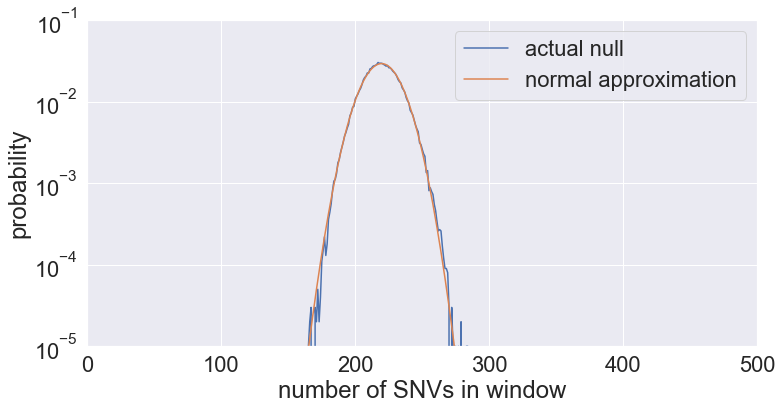

In [5]:
plot_estimated_vs_actual_null_distribution(windows_scores_annotations_noncoding.sample(n=1))

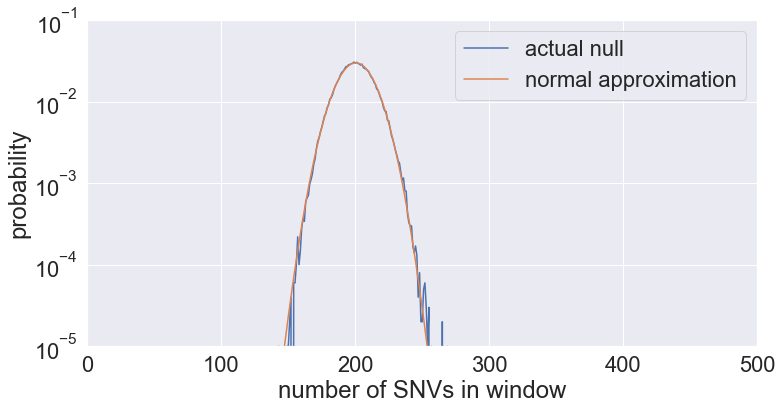

In [6]:
plot_estimated_vs_actual_null_distribution(fetch_constrained_windows(windows_scores_annotations_noncoding).sample(n=1))

## The normal distribution is a good approximation to the null distribution for ALL windows 



Cross entropy (in bits) between the true null distribution $q(x)$ and the normal distribution $p_\theta(x)$ is estimated by

$$ 
H(q, p_\theta) = -\frac{1}{N} \sum_{i=1}^N \log_2 p_\theta (x_i) = - \sum_{x} \hat{q}(x) \log_2 p_\theta (x) ,
$$ 

where $\{x_i\}$ is a sample from $q(x)$, 
and $\hat{q}(x)$ is an estimate of the true null distribution: 

$$ 
\hat{q}(x) = \frac{|\{x_i: x_i= x\}}{N}.
$$ 


If $p_\theta(x) = q(x)$, then the cross entropy reduces to the entropy 
of $q(x)$, which is estimated by: 

$$ 
H(q) = - \sum_{x} \hat{q}(x) \log_2 \hat{q} (x) ,
$$ 

The KL divergence measures how far $p_\theta(x)$ is from $q(x)$, in bits, and is estimated by: 

$$ 
D_{KL}(q || p_\theta) = H(q, p_\theta) - H(q) ,
$$ 

while the relative distance between $p_\theta(x)$ and $q(x)$ is estimated by 

$$ 
\frac{D_{KL}(q || p_\theta)}{H(q)} .
$$ 


In [7]:
from tqdm import tqdm 

def p_theta(xi, theta_mean, theta_variance): 
#     from scipy.stats import poisson 
#     return poisson.pmf(xi, theta_mean)
#     from scipy.stats import expon 
#     return expon.pdf(xi)
    # probability that that SNV count lies in [xi, xi+1):
    return norm.pdf(xi, theta_mean, np.sqrt(theta_variance))
    
def plot_goodness_of_fit(df):
    model = read_model_wrapper()

    goodness_of_fit = []
    for (
        region, 
        theta_mean, 
        theta_variance
    ) in tqdm(
        zip(
            df.apply(lambda row: row['chromosome'] + ':' + str(row['start']) + '-' + str(row['end']), axis=1), 
            df[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
            df[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        ), 
        total=len(df)
    ): 
        d = fetch_distribution_N(region, model, NUMBER_EXAMPLES)
        qhat_threshold = 1e-3/NUMBER_EXAMPLES
        cross_entropy = -np.sum([
            qhat*np.log2(p_theta(x, theta_mean, theta_variance)) 
            for x, qhat in zip(d['n'], d['p(n)']) 
            if qhat > qhat_threshold
        ])
        entropy = -np.sum([qhat*np.log2(qhat) for qhat in d['p(n)'] if qhat > qhat_threshold])
        KL_divergence = cross_entropy - entropy 
        goodness_of_fit.append(KL_divergence/entropy)
    
    plt.hist(goodness_of_fit)
    plt.xlabel('goodness of fit [(cross entropy - entropy)/entropy]')
    plt.ylabel('number of windows')
    plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


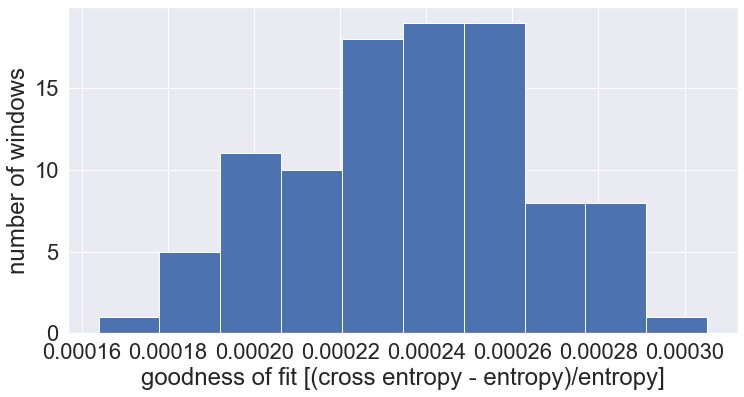

In [8]:
plot_goodness_of_fit(windows_scores_annotations_noncoding.sample(n=100))  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:40<00:00,  2.81s/it]


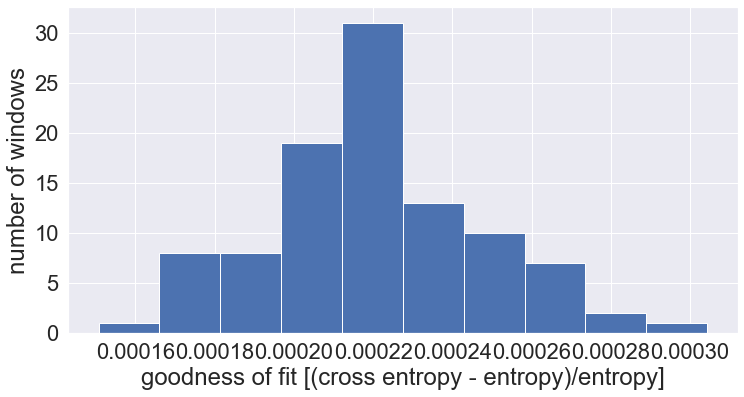

In [9]:
plot_goodness_of_fit(fetch_constrained_windows(windows_scores_annotations_noncoding).sample(n=100))  

## Central Limit Theorem (CLT) explains why the null distribution is approximately normal 

The number of distinct ALT alleles $N_i$ at a site $i$ is a categorical variable with site-dependent mean $\langle N_i \rangle$ and variance $\mbox{var} (N_i)$. (See [model](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb).) Since these random variables are independent, but not identically distributed, the [Lyapunov CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Lyapunov_CLT) applies. This theorm states that, if the number of sites $l$ in a window is large enough (we consider $l=1000$), then $N = \sum_i N_i$ is distributed as: 

\begin{equation}
\frac{N - \langle N \rangle}{\sqrt{\mbox{var}(N)}} \sim \mbox{Normal}(0, 1) 
\end{equation}

where 

$$ 
\langle N \rangle = \sum_i \langle N_i \rangle 
$$ 

and 

$$ 
\mbox{var}(N) = \sum_i \mbox{var}(N_i).
$$

There are two corollaries: 

1. If one simulates SNV counts for a given window many times, then the resulting distribution of SNV counts will be Normal. 
2. If one simulates many windows, and generates a single SNV count for each window, then the distribution of z-scores, of those windows will be a standard normal. 

## TODO: compute qq plot 

In [10]:
def compute_pvalue(row): 
    N_observed, theta_mean, theta_variance = (
        row['N_observed'],
        row[f'N_mean_null_{KMER_SIZE}_{TRAIN_SET_LABEL}'], 
        row[f'N_variance_null_{KMER_SIZE}_{TRAIN_SET_LABEL}']
    )
    return norm.cdf(N_observed, theta_mean, np.sqrt(theta_variance))    

def generate_qq_plot(df):
    p_values = df.apply(compute_pvalue, axis=XXX)
    
    # https://github.com/petermchale/QQ-plots/blob/master/qq-plots.pdf
    sorted_p_values = sort(p_values)
    expected_p_values = [i/(len(df)+1)for i in range(len(df))]
    plt.plot(-np.log10(expected_p_values), -np.log10(sorted_p_values))
    plt.xlabel('-log10(<PV_i>)')
    plt.ylabel('-log10(PV_i)')

# TODO: COMMIT and add to slide deck for Tuesday meeting 